# Pre-computing the APOGEE-1 and 2 DR16 selection function

In this notebook, we will run through the computation of the DR16 selection function.

To do this, you will need the [`apogee`](https://github.com/jobovy/apogee) and [`mwdust`](https://github.com/jobovy/mwdust) python packages. You should also ensure that you have the set of low metallicity isochrones from PARSEC.

In [1]:
import os
import sys
#ensure that our APOGEE python will read DR16!
os.environ['RESULTS_VERS'] = 'l33'
import numpy as np
import matplotlib.pyplot as plt
import apogee.select as apsel
import apogee.tools.read as apread
import mwdust
import tqdm
import dill as pickle
import multiprocessing
import utils
import densprofiles
from isodist import FEH2Z, Z2FEH
import corner
import matplotlib
import safe_colours
from galpy.util import bovy_plot #only necessary if you want to plot...
safe_colours = safe_colours.initialise()
col_dict = safe_colours.distinct_named()
cm_rainbow = safe_colours.colourmap('rainbow')
cm_heat = safe_colours.colourmap('heat')
cm_diverging = safe_colours.colourmap('diverging')
#params = {'axes.labelsize': 14, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'text.usetex': True, 'lines.linewidth': 1,
     #     'axes.titlesize': 14, 'font.family': 'serif'}
#plt.rcParams.update(params)

columnwidth = 240./72.27
textwidth = 504.0/72.27

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

/Users/qpasa/.local/lib/python3.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa



In [2]:
#load allStar (main sample w/ Leung & Bovy distances, removing duplicates)
allstar = apread.allStar(main=True, rmdups=True,use_astroNN_distances=True)
# allstar = apread.allStar(main=True, rmdups=True, exclude_star_bad=True, exclude_star_warn=True, use_astroNN_distances=True, use_astroNN_ages=True)
print(str(len(allstar))+' stars in total sample.')


/Users/qpasa/opt/anaconda3/lib/python3.7/site-packages/apogee-1.-py3.7.egg/apogee/tools/read.py:1336: UserWarning: Adding distances from Leung & Bovy (2019b)
  warnings.warn("Adding distances from Leung & Bovy (2019b)")



100%|██████████| 105448/105448 [00:13<00:00, 7581.08it/s]


357167 stars in total sample.                                                   


# The 'raw' selection function

First, we need to evaluate or load up the combined APOGEE-1 and 2 selection function, which is a function of the dereddened $(J-K_s)_0$ colour and apparent $H$ magnitude.

We will also determine, for the sample loaded above, which stars are in the 'statistical sample' for APOGEE-1 and 2. This is the subset of stars which are in completed observation cohorts.

In [3]:
#load selection function/statIndx/effsel if they exist, if not, evaluate and pickle (set force to True for brute force re-evaluation)
# This can take some time if you havent computed the SF before!
force = False
if os.path.exists('../sav/apodr16_csf.dat') and not force:
    with open('../sav/apodr16_csf.dat', 'rb') as f:
        apo = pickle.load(f)
else:
    apo = apsel.apogeeCombinedSelect(year=7)
    del apo._specdata, apo._photdata
    with open('../sav/apodr16_csf.dat', 'wb') as f:
        pickle.dump(apo, f)
force = False
print('yep')
#determine statistical sample and pickle file
if os.path.exists('../sav/statIndx_dr16.dat') and not force:
    with open('../sav/statIndx_dr16.dat', 'rb') as f:
        statIndx = pickle.load(f)
else:
    statIndx = apo.determine_statistical(allstar)
    with open('../sav/statIndx_dr16.dat', 'wb') as f:
        pickle.dump(statIndx, f)

yep


We can then make a plot showing the selection fraction as function of sky position and colour-magnitude bin:

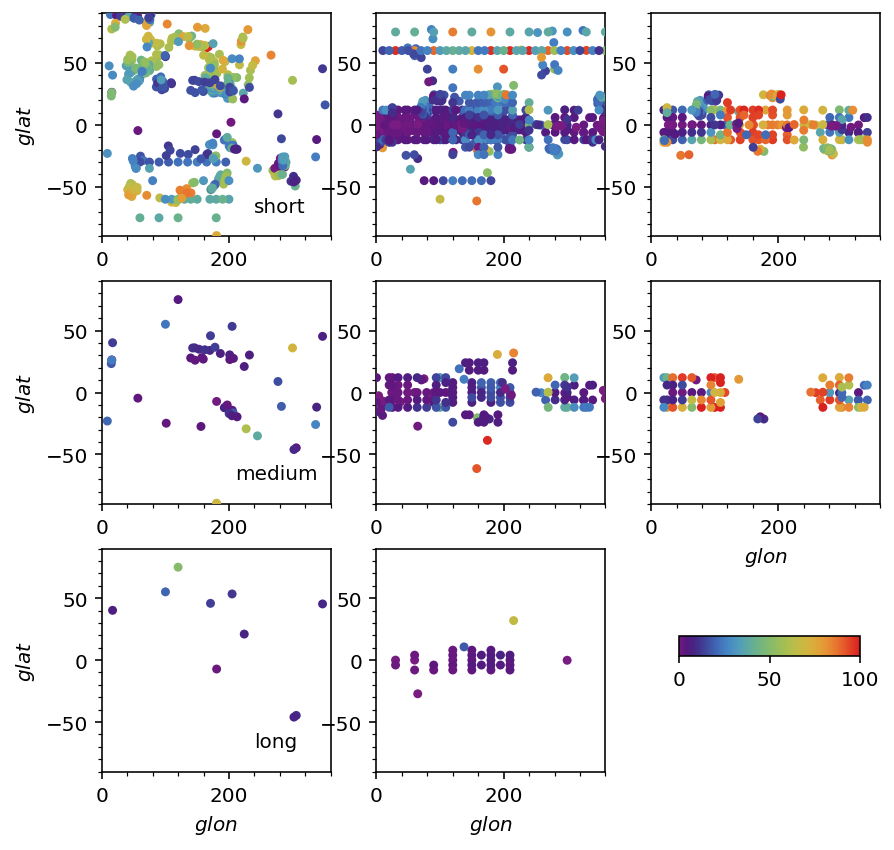

In [4]:
def sflb_plot(apo, cohort, jk, gcf=False, xlabel=None, ylabel=None):
    plotSF= np.ones(len(apo._locations))*np.nan
    mask = np.zeros(len(apo._locations), dtype=bool)
    bins = np.zeros(len(apo._locations), dtype=int)
    for ii,loc in enumerate(apo._locations):
        nbins = apo.NColorBins(loc)
        for i in range(nbins):
            jkmin = round(apo.JKmin(loc, bin=i), 2)
            if jkmin == jk:
                mask[ii] = 1
                bins[ii] = i
    for ii in range(len(apo._locations)):
        if mask[ii]:
            plotSF[ii]= np.atleast_1d(\
              apo._selfunc['%i%s' % (apo._locations[ii],
                                      cohort[0])]\
                    (apo.__dict__['_%s_hmax' % cohort]))[bins[ii]]*100.
    clabel=r'a'#$\mathrm{%s\ cohort\ selection\ fraction\, (\%%)}$' % cohort
    vmin= 0.
    vmax= 100.
    bovy_plot.bovy_plot(apo._apogeeField['GLON'],
                        apo._apogeeField['GLAT'],
                        c=plotSF,s=20,
                        scatter=True,
                        edgecolor='none',
                        colorbar=False,
                        vmin=vmin,vmax=vmax,crange=[vmin,vmax],
                        xrange=[0.,360.],yrange=[-90.,90.],
                        xlabel=xlabel,
                        ylabel=ylabel,
                        clabel=clabel,
                        zorder=10,gcf=gcf, cmap=cm_rainbow)

fig = plt.figure()
xlabel = r'glon'
ylabel = r'glat'
anno_x, anno_y = 210,-70
fig.set_size_inches(textwidth,textwidth)
plt.subplot(3,3,1)
sflb_plot(apo,'short',0.3, gcf=True, ylabel=ylabel)
ax = plt.gca()
#ax.set_title(r'$(J-K_s)_0 > 0.3$')
plt.text(anno_x+30, anno_y,r'short',  zorder=10)
plt.subplot(3,3,4)
sflb_plot(apo,'medium',0.3, gcf=True, ylabel=ylabel)
plt.text(anno_x, anno_y,r'medium', zorder=10)
plt.subplot(3,3,7)
sflb_plot(apo,'long',0.3, gcf=True, xlabel=xlabel, ylabel=ylabel)
plt.text(anno_x+30, anno_y,r'long', zorder=10)
plt.subplot(3,3,2)
sflb_plot(apo,'short',0.5, gcf=True)
ax = plt.gca()
#ax.set_title(r'$(J-K_s)_0 > 0.5$')
#plt.text(anno_x+15, anno_y,r'short, $(J-K_S)_0 > 0.5$',bbox=dict(facecolor='White', edgecolor='black', alpha=0.3,boxstyle='round'), zorder=10)
plt.subplot(3,3,5)
sflb_plot(apo,'medium',0.5, gcf=True)
#plt.text(anno_x-12, anno_y,r'medium, $(J-K_S)_0 > 0.5$',bbox=dict(facecolor='White', edgecolor='black', alpha=0.3,boxstyle='round'), zorder=10)
plt.subplot(3,3,8)
sflb_plot(apo,'long',0.5, gcf=True, xlabel=xlabel)
#plt.text(anno_x+17, anno_y,r'long, $(J-K_S)_0 > 0.5$',bbox=dict(facecolor='White', edgecolor='black', alpha=0.3,boxstyle='round'), zorder=10)
plt.subplot(3,3,3)
sflb_plot(apo,'short',0.8, gcf=True)
ax = plt.gca()
#ax.set_title(r'$(J-K_s)_0 > 0.8$')
#plt.text(anno_x+15, anno_y,r'short, $(J-K_S)_0 > 0.5$',bbox=dict(facecolor='White', edgecolor='black', alpha=0.3,boxstyle='round'), zorder=10)
plt.subplot(3,3,6)
sflb_plot(apo,'medium',0.8, gcf=True, xlabel=xlabel)
#plt.text(anno_x-12, anno_y,r'medium, $(J-K_S)_0 > 0.5$',bbox=dict(facecolor='White', edgecolor='black', alpha=0.3,boxstyle='round'), zorder=10)
#subplot(3,3,9)
#sflb_plot(apo,'long',0.8, gcf=True, xlabel=xlabel)
#plt.text(anno_x+17, anno_y,r'long, $(J-K_S)_0 > 0.5$',bbox=dict(facecolor='White', edgecolor='black', alpha=0.3,boxstyle='round'), zorder=10)
#fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.7,0.24,0.18,0.02])

plt.colorbar(cax=cax, orientation='horizontal',)# label=r'Selection Fraction [\%]')
plt.savefig('../plots/combinedsf_lb.pdf', format='pdf', bbox_inches='tight')

# Computing the effective selection function on a grid of locations and distance modulus

We now need to pre-compute the effective spatial selection function on the same grid which we will later evaluate the proposed density models in our maximum likelihood and MCMC. This requires a set of PARSEC isochrones which we will use for the MC integration of colour magnitude space. We also need the `Combined15` dustmap from [`mwdust`]([https://github.com/jobovy/mwdust])

We need to make two files, one which has the effective selection function for each $\mathrm{[Fe/H]}$ bin that we will adopt in the analysis, and another which is the effective selection function based on the full range of $\mathrm{[Fe/H]}$. If you dont have these already calculated and saved, this can also take a while, even when multiprocessed (by default, this will run on $N_{\mathrm{cores}}/2$).

In [4]:
#load or evaluate the effective selection function on the required [Fe/H] grid (defined in 'bins')
def _calc_effsel_onelocation(i): 
    #computes the effective selection function along the line of sight of one APOGEE location.
    loc = apo._locations[i]
    if np.sum([np.nansum(apo._nspec_short[i]),np.nansum(apo._nspec_medium[i]),np.nansum(apo._nspec_long[i])]) < 1.:
        effsel = np.zeros(len(ds))
    elif apo.JKmin(loc) >= 0.5:
        effsel = apof(loc, ds, MH=H, JK0=(J-K))*apo.area(loc)
    elif apo.JKmin(loc) < 0.5:
        effsel = apof(loc, ds, MH=p3H, JK0=(p3J-p3K))*apo.area(loc)
    return effsel

#set force to True for a recalculation of an existing eff. sel. grid.
force = False 
#Define the Fe/H bins, which we will be adopting later.
bins = [-3,-1.6,-1.4,-1.2,-1.] 
# Set the parameters of the distance modulus grid
nsamples=2000
ndistmods=301
minmax_distmods=[7.,19.]
nthreads = int(multiprocessing.cpu_count()//2)
#load the isochrone grid (make sure this is downloaded first!)
isorec = utils.generate_lowfeh_isogrid()
# dustmap from mwdust
dmap = mwdust.Combined19()
#initiate eff sel instance
apof = apsel.apogeeEffectiveSelect(apo, dmap3d=dmap)
distmods = np.linspace(minmax_distmods[0], minmax_distmods[1], ndistmods)
ds = 10.**(distmods/5-2)
#if effsel grid exists, load, if not, calculate it
if os.path.exists('../essf/effsel_lowfehgrid_fehbins_inclArea.dat') and not force:
    sys.stdout.write('\r'+"loading saved effective selection function for APOGEE fields...\r")
    sys.stdout.flush()
    with open('../essf/effsel_lowfehgrid_fehbins_inclArea.dat', 'rb') as f:
        out = np.load(f)
else:
    sys.stdout.write('\r'+"calculating effective selection function for APOGEE fields...\r")
    sys.stdout.flush()
    #loop over the Fe/H bins defined (sampling right Fe/H range from isochrones)
    out = np.zeros((len(bins)-1,len(apo._locations),ndistmods))
    for i in range(len(bins)-1):
        niso, p3niso = utils.APOGEE_iso_samples(nsamples, isorec, fehrange=[bins[i], bins[i+1]], lowfehgrid=True)
        H, J, K = np.array(niso['Hmag'].data), np.array(niso['Jmag'].data), np.array(niso['Ksmag'].data)
        p3H, p3J, p3K = np.array(p3niso['Hmag'].data), np.array(p3niso['Jmag'].data), np.array(p3niso['Ksmag'].data)
        with multiprocessing.Pool(nthreads) as p:
            outarea = list(tqdm.tqdm(p.imap(_calc_effsel_onelocation, range(0,len(apo._locations))), total=len(apo._locations)))
        out[i] = np.array(outarea)
    with open('../essf/effsel_lowfehgrid_fehbins_inclArea.dat', 'wb') as f:
        np.save(f, out)

100%|██████████| 30/30 [00:04<00:00,  8.10it/s]


In [5]:
import utils
#load or evaluate the effective selection function on the required [Fe/H] grid (defined in 'bins')
def _calc_effsel_onelocation(i): 
    #computes the effective selection function along the line of sight of one APOGEE location.
    loc = apo._locations[i]
    if np.sum([np.nansum(apo._nspec_short[i]),np.nansum(apo._nspec_medium[i]),np.nansum(apo._nspec_long[i])]) < 1.:
        effsel = np.zeros(len(ds))
    elif apo.JKmin(loc) >= 0.5:
        effsel = apof(loc, ds, MH=H, JK0=(J-K))*apo.area(loc)
    elif apo.JKmin(loc) < 0.5:
        effsel = apof(loc, ds, MH=p3H, JK0=(p3J-p3K))*apo.area(loc)
    return effsel

#repeat the above for a single [Fe/H] selection across the whole range
force = False

# Set the parameters of the distance modulus grid
nsamples=2000
ndistmods=301
minmax_distmods=[7.,19.]
nthreads = int(multiprocessing.cpu_count()//2)
#load the isochrone grid (make sure this is downloaded first!)
isorec = utils.generate_lowfeh_isogrid()
# dustmap from mwdust
dmap = mwdust.Combined19()
#initiate eff sel instance
apof = apsel.apogeeEffectiveSelect(apo, dmap3d=dmap)
distmods = np.linspace(minmax_distmods[0], minmax_distmods[1], ndistmods)
ds = 10.**(distmods/5-2)
niso, p3niso = utils.APOGEE_iso_samples(nsamples, isorec, fehrange=[-3., -1.], lowfehgrid=True)
H, J, K = np.array(niso['Hmag'].data), np.array(niso['Jmag'].data), np.array(niso['Ksmag'].data)
p3H, p3J, p3K = np.array(p3niso['Hmag'].data), np.array(p3niso['Jmag'].data), np.array(p3niso['Ksmag'].data)
distmods = np.linspace(minmax_distmods[0], minmax_distmods[1], ndistmods)
ds = 10.**(distmods/5-2)
if os.path.exists('../essf/effsel_grid_inclArea19.dat') and not force:
    sys.stdout.write('\r'+"loading saved effective selection function for APOGEE fields...\r")
    sys.stdout.flush()
    with open('../essf/effsel_grid_inclArea19.dat', 'rb') as f:
        outarea = pickle.load(f)
else:
    sys.stdout.write('\r'+"calculating effective selection function for APOGEE fields...\r")
    sys.stdout.flush()
    with multiprocessing.Pool(nthreads) as p:
        outarea = list(tqdm.tqdm(p.imap(_calc_effsel_onelocation, range(0,len(apo._locations))), total=len(apo._locations)))
    outarea = np.array(outarea)
    with open('../essf/effsel_grid_inclArea19.dat', 'wb') as f:
        pickle.dump(outarea, f)

100%|██████████| 30/30 [00:02<00:00, 12.26it/s]


 13%|█▎        | 148/1173 [26:43<4:12:27, 14.78s/it]

/Users/qpasa/opt/anaconda3/lib/python3.7/site-packages/apogee-1.-py3.7.egg/apogee/select/apogeeSelect.py:2559: UserWarning: Different designs for this field have different radii; returning the first of these...
  warnings.warn("Different designs for this field have different radii; returning the first of these...")



100%|██████████| 1173/1173 [2:12:13<00:00,  6.76s/it] 


### Once everything here is computed and saved, you can move on to the analysis.